In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import time

In [2]:
# Find all hyperparams of your model with get_params()
model = SVC()
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

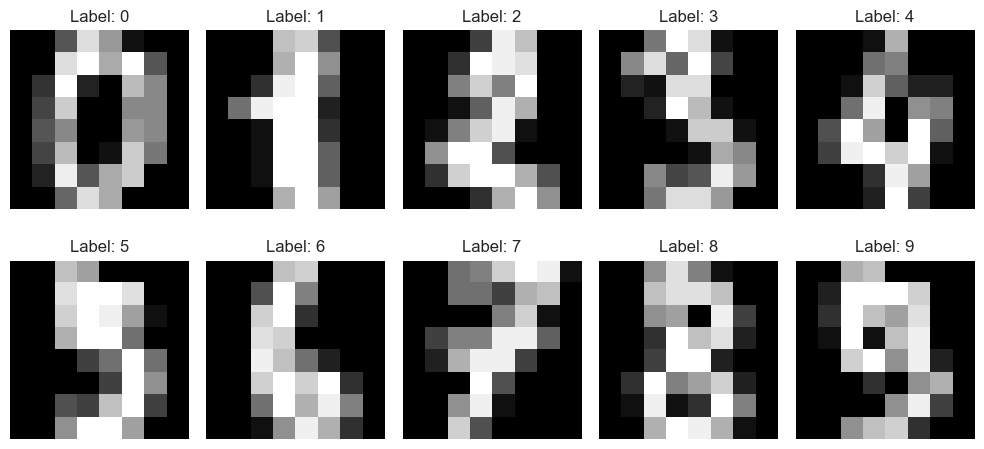

In [17]:
# Get some training data
X, y = load_digits(n_class=10, return_X_y=True)

# visualise a few digits
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, img, label in zip(axes.ravel(), X, y):
    ax.imshow(img.reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# make the task more difficult by adding noise
np.random.seed(0)
X += np.random.normal(size=X.shape, scale=np.std(X))

#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

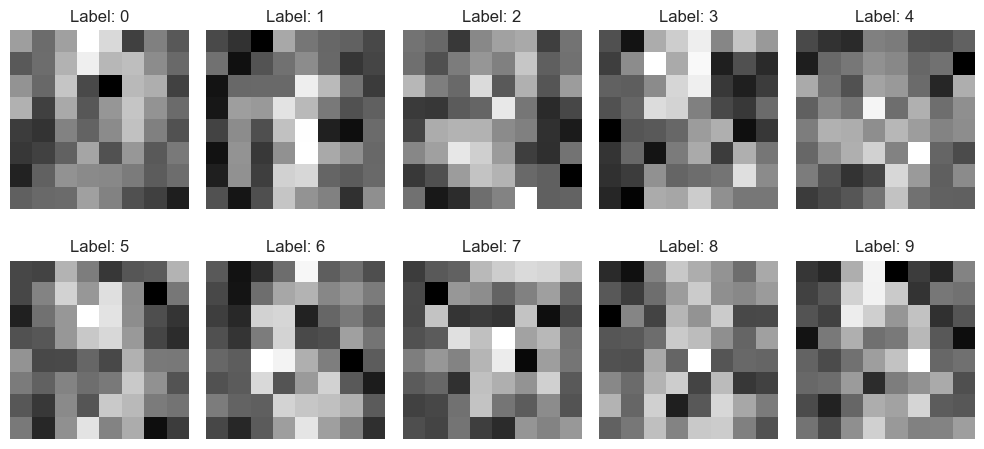

In [19]:
# visualise a few digits with the added noise
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, img, label in zip(axes.ravel(), X, y):
    ax.imshow(img.reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Grid Search

In [6]:
# use a full grid over all parameters
param_grid = {
    'C': np.exp(np.linspace(-6, 6, num=3)), # log-uniform
    'gamma': np.exp(np.linspace(-6, 1, num=2)),
    'degree': np.linspace(1, 8, num=2).astype(int),  # integer valued parameter
    'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
}

grid_search = GridSearchCV(SVC(), param_grid=param_grid)

start = time()
result_grid = grid_search.fit(X_train, y_train)
print("time:", time() - start)

time: 13.789446830749512


In [7]:
# summarize result
print('Best Score: %s' % result_grid.best_score_)
print('Best Hyperparameters: %s' % result_grid.best_params_)

Best Score: 0.7550075726283906
Best Hyperparameters: {'C': 0.0024787521766663585, 'degree': 1, 'gamma': 0.0024787521766663585, 'kernel': 'linear'}


# Baysian Optimisation

In [8]:
from skopt import BayesSearchCV

opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'), # log-uniform: search over p = exp(x) by varying x
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

start = time()
opt.fit(X_train, y_train)
print("time:", time() - start)

time: 88.54710102081299


In [9]:
#summarise results
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print('Best Hyperparameters: %s',opt.best_params_)

val. score: 0.8247958426132146
test score: 0.7777777777777778
Best Hyperparameters: %s OrderedDict({'C': 1000000.0, 'degree': 5, 'gamma': 0.0001338038067953818, 'kernel': 'rbf'})


# Random Search

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# use a full grid over all parameters
param_grid = {
    'C': np.exp(np.linspace(-6, 6, num=3)), # log-uniform
    'gamma': np.exp(np.linspace(-6, 1, num=2)),
    'degree': np.linspace(1, 8, num=2).astype(int),  # integer valued parameter
    'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
}

grid_search = RandomizedSearchCV(SVC(), param_distributions=param_grid)

start = time()
result_random = grid_search.fit(X_train, y_train)
print("time:", time() - start)

time: 3.595551013946533


In [11]:
# summarize result
print('val Score: %s' % result_random.best_score_)
print("test score: %s" % result_random.score(X_test, y_test))
print('Best Hyperparameters: %s' % result_random.best_params_)

val Score: 0.7550075726283906
test score: 0.7355555555555555
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.0024787521766663585, 'degree': 1, 'C': 1.0}


# Genetic Algorithms

In [12]:
# --->>> Your Turn <<<---
# Try to apply hyperparameter tuning with genetic alorithms
# see https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/basic_usage.html
# in case you need to install the package, uncomment the following lines:
#!conda install conda-forge::sklearn-genetic -y
#!conda install conda-forge::sklearn-genetic-opt -y

In [13]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

# we use the the same param_grid as before, but have to specify the parameter types
param_grid = {
    'C': Continuous(np.exp(-6), np.exp(6)), 
    'gamma': Continuous(np.exp(-6), np.exp(1)),
    'degree': Integer(1, 8),  # integer valued parameter
    'kernel': Categorical(['linear', 'poly', 'rbf'])  # categorical parameter
}

# The main class from sklearn-genetic-opt
evolved_estimator = GASearchCV(estimator=SVC(),
                              cv=5,
                              scoring='accuracy',
                              param_grid=param_grid,
                              n_jobs=-1, # use all available cores
                              verbose=True,
                              population_size=20,
                              generations=30)

evolved_estimator.fit(X_train, y_train)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.490053	0.313752   	0.78619    	0.106165   
1  	40    	0.654119	0.231157   	0.806981   	0.106165   
2  	40    	0.759908	0.0237984  	0.78619    	0.737935   
3  	40    	0.789641	0.0206476  	0.826284   	0.737935   
4  	40    	0.800927	0.0111634  	0.815137   	0.78619    
5  	40    	0.810318	0.00822747 	0.826284   	0.78619    
6  	40    	0.816925	0.00991863 	0.826284   	0.78619    
7  	40    	0.821417	0.00619968 	0.826284   	0.806981   
8  	40    	0.825727	0.00242941 	0.826284   	0.815137   
9  	40    	0.824279	0.0087382  	0.826284   	0.78619    
10 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
11 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
12 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
13 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
14 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
15 	40    	0.826284	3.33067e-16	0.826284   	0.826284   
16 	40    	0.826284	3.33067e-16	0.826284   	0.82

GASearchCV(cv=5,
           estimator=SVC(C=137.04743549127372, gamma=2.139875861708725,
                         kernel='poly'),
           generations=30, n_jobs=-1,
           param_grid={'C': <sklearn_genetic.space.space.Continuous object at 0x33a79fc20>,
                       'degree': <sklearn_genetic.space.space.Integer object at 0x33b6d8230>,
                       'gamma': <sklearn_genetic.space.space.Continuous object at 0x33b823e30>,
                       'kernel': <sklearn_genetic.space.space.Categorical object at 0x33b02bd70>},
           population_size=20, return_train_score=True, scoring='accuracy',
           warm_start_configs=[])

In [14]:
# summarize result
print('val Score: %s' % evolved_estimator.best_score_)
print("test score: %s" % evolved_estimator.score(X_test, y_test))
print('Best Hyperparameters: %s' % result_random.best_params_)

val Score: 0.8262839047225665
test score: 0.7911111111111111
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.0024787521766663585, 'degree': 1, 'C': 1.0}


/Users/nyfe/anaconda3/envs/MLCO2_test/lib/python3.12/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


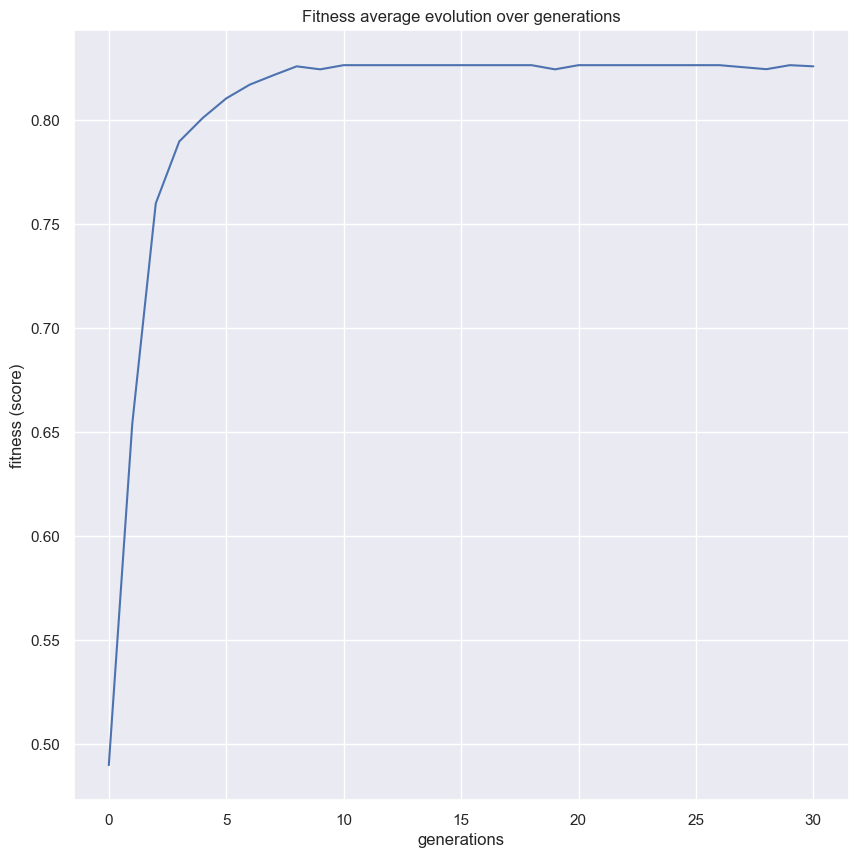

In [15]:
from sklearn_genetic.plots import plot_fitness_evolution
plot_fitness_evolution(evolved_estimator)
plt.show()

In [16]:
# create pandas dataframe with the results
df = pd.DataFrame([result_grid.best_params_, opt.best_params_, result_random.best_params_, evolved_estimator.best_params_])
df['method'] = (['GridSearch','BayesianOptimization','RandomSearch','GeneticAlgorithm'])
df['test_accuracy'] = ([grid_search.score(X_test, y_test),
                        opt.score(X_test, y_test),
                        result_random.score(X_test, y_test),
                        evolved_estimator.score(X_test, y_test)])

from IPython.display import display
display(df)

,C,degree,gamma,kernel,method,test_accuracy
0,0.002479,1,0.002479,linear,GridSearch,0.735556
1,1000000.000000,5,0.000134,rbf,BayesianOptimization,0.777778
2,1.000000,1,0.002479,poly,RandomSearch,0.735556
3,137.047435,3,2.139876,poly,GeneticAlgorithm,0.791111


## Halving Grid Search
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html

In [51]:
# do the same with HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# we use the the same param_grid endpoints as before, but with more intermediate values
param_grid = {
    'C': np.exp(np.linspace(-6, 6, num=6)), # log-uniform
    'gamma': np.exp(np.linspace(-6, 1, num=4)),
    'degree': np.linspace(1, 8, num=4).astype(int),  # integer valued parameter
    'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
}

halving_grid_search = HalvingGridSearchCV(SVC(), 
                                          param_grid=param_grid, 
                                          factor=2, 
                                          min_resources=42,
                                          random_state=0,)

start = time()
halving_result_grid = halving_grid_search.fit(X_train, y_train)
print("time:", time() - start)

time: 10.099989891052246


## Summary

In [52]:
# summarize result
print('val Score: %s' % halving_result_grid.best_score_)
print("test score: %s" % halving_result_grid.score(X_test, y_test))
print('Best Hyperparameters: %s' % halving_result_grid.best_params_)

val Score: 0.7391943627586972
test score: 0.7066666666666667
Best Hyperparameters: {'C': 3.320116922736545, 'degree': 1, 'gamma': 0.0024787521766663585, 'kernel': 'poly'}


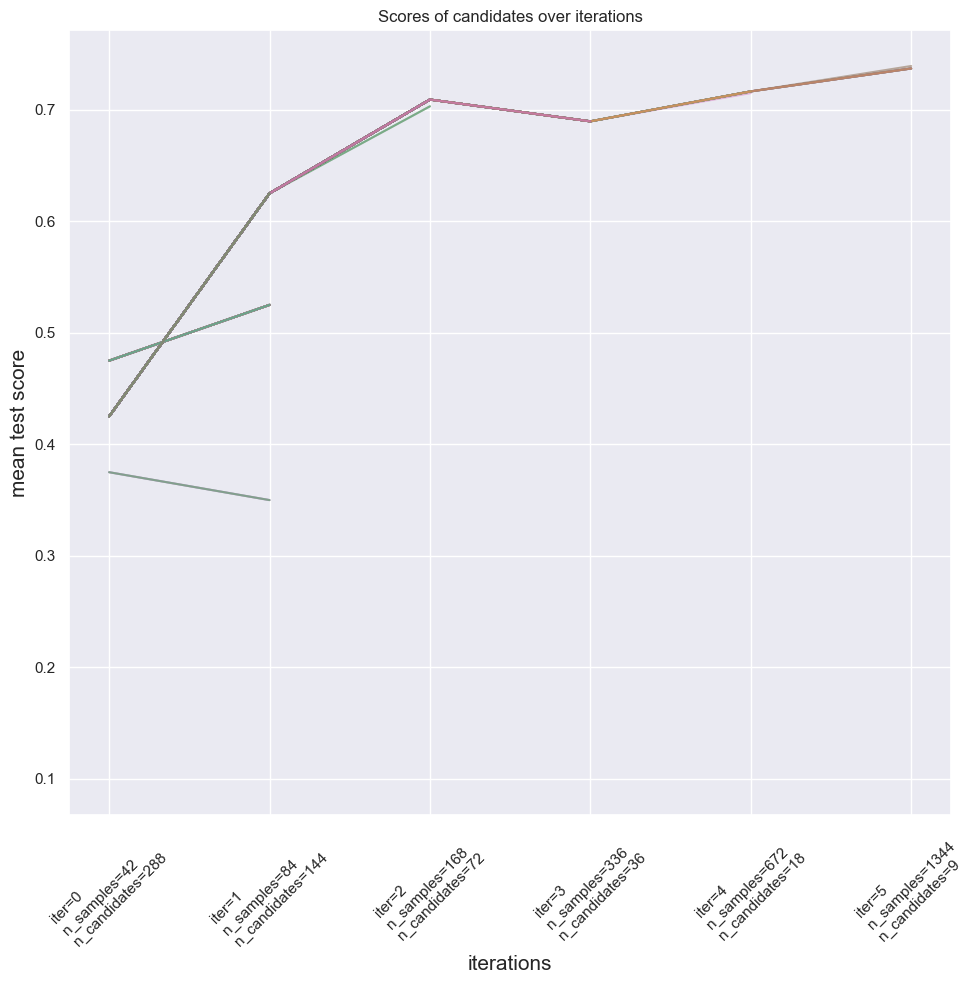

In [53]:
# Visualisation
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html

results = pd.DataFrame(halving_result_grid.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_result_grid.n_resources_[i]}\nn_candidates={halving_result_grid.n_candidates_[i]}"
    for i in range(halving_result_grid.n_iterations_)
]

ax.set_xticks(range(halving_result_grid.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

## HalvingRandom Search
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html

In [54]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV

# we use the the same param_grid endpoints as before, but with more intermediate values
param_grid = {
    'C': np.exp(np.linspace(-6, 6, num=2)), # log-uniform
    'gamma': np.exp(np.linspace(-6, 1, num=4)),
    'degree': np.linspace(1, 8, num=4).astype(int),  # integer valued parameter
    'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
}

halving_random_search = HalvingRandomSearchCV(SVC(), 
                                          param_distributions=param_grid, 
                                          factor=2, 
                                          min_resources=42,
                                          random_state=0,)

start = time()
halving_random_grid = halving_random_search.fit(X_train, y_train)
print("time:", time() - start)

time: 1.2194187641143799


In [55]:
# summarize result
print('val Score: %s' % halving_random_grid.best_score_)
print("test score: %s" % halving_random_grid.score(X_test, y_test))
print('Best Hyperparameters: %s' % halving_random_grid.best_params_)

val Score: 0.7369611052543972
test score: 0.6977777777777778
Best Hyperparameters: {'kernel': 'linear', 'gamma': 0.0024787521766663585, 'degree': 3, 'C': 403.4287934927351}


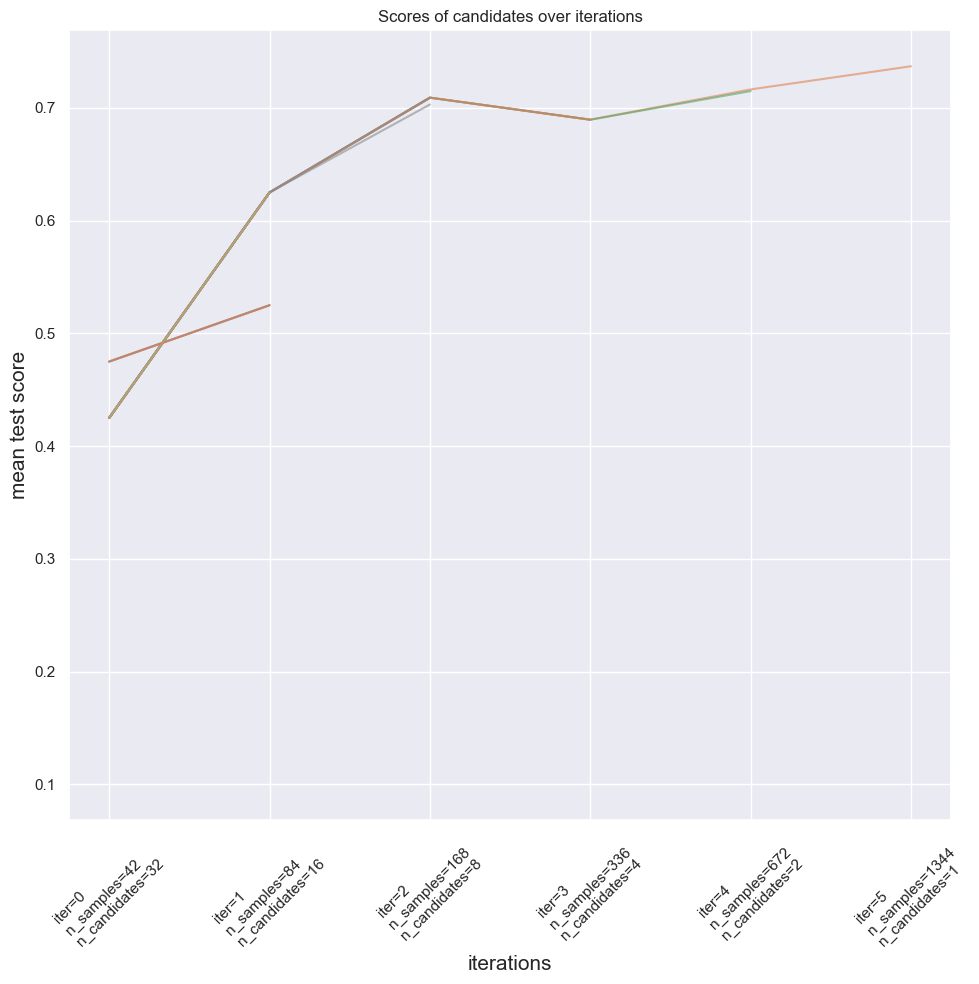

In [56]:
# Visualisation
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html

results = pd.DataFrame(halving_random_grid.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={halving_random_grid.n_resources_[i]}\nn_candidates={halving_random_grid.n_candidates_[i]}"
    for i in range(halving_random_grid.n_iterations_)
]

ax.set_xticks(range(halving_random_grid.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
plt.show()

## Summary

In [58]:
# create pandas dataframe with the results
df = pd.DataFrame([result_grid.best_params_, 
                   opt.best_params_, 
                   result_random.best_params_, 
                   evolved_estimator.best_params_,
                   halving_grid_search.best_params_,
                   halving_random_search.best_params_])
df['method'] = (['GridSearch',
                 'BayesianOptimization',
                 'RandomSearch',
                 'GeneticAlgorithm',
                 'HalvingGridSearch',
                 'HalvingRandomSearch'])
df['test_accuracy'] = ([grid_search.score(X_test, y_test),
                        opt.score(X_test, y_test),
                        result_random.score(X_test, y_test),
                        evolved_estimator.score(X_test, y_test),
                        halving_grid_search.score(X_test, y_test),
                        halving_random_search.score(X_test, y_test)])

from IPython.display import display
display(df)

,C,degree,gamma,kernel,method,test_accuracy
0,0.002479,1,0.002479,linear,GridSearch,0.735556
1,1000000.000000,5,0.000134,rbf,BayesianOptimization,0.777778
2,1.000000,1,0.002479,poly,RandomSearch,0.735556
3,137.047435,3,2.139876,poly,GeneticAlgorithm,0.791111
4,3.320117,1,0.002479,poly,HalvingGridSearch,0.706667
5,403.428793,3,0.002479,linear,HalvingRandomSearch,0.697778


In [40]:
np.log2(1347)

10.395534135462302

In [41]:
1347/16

84.1875